<img src='logo.png' style='display: block;height: 61px;float: left;padding: .75rem 1.25rem;'>

# Desafío - Inferencia de tópicos con EM
* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el `.zip` a la seccióncorrespondiente.

## Descripción

* En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los `csv` se encuentra en la carpeta `dump`.
* Cada `csv` tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, elgénero musical del artista, el nombre de la canción y las letras.
* En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico quepueda identificar el género musical más probable dado la letra de una canción.
* Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz dedocumentos.

## Ejercicio 1: Preparar el ambiente de trabajo

* Importe los módulos `numpy`, `pandas`, `matplotlib`, `seaborn`, `glob` y `os` siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiplesarchivos dentro de la carpeta dump.
* Para ello genere un objeto que guarde en una lista todos los archivos alojados en dumputilizando `glob.glob` y `os.getcwd()` para extraer las rutas absolutas. Posteriormente genere un objeto `pd.DataFrame` que contenga todos los csv.
* Asegúrese de eliminar la columna `Unnamed: 0` que se genera por defecto.

> Se utilizan librerías bases para el tratamiento de datos y algunos aspectos básicos de cálculo y gráficos.

In [1]:
# Se importa libreria para el manejo de bases de datos
import pandas as pd
# Se importa libreria para el manejo de operaciones de cálculo
import numpy as np
# Se importa libreria para el manejo de gráficos
import matplotlib.pyplot as plt
# Se importa libreria para manejo de funciones estadisticas y probabilidades
import seaborn as sns
# Librería para visualizar patrones de datos perdidos
import missingno as msngo
# Se importa libreria para el menejo de warning
import warnings
# Se importa libreria para el menejo de expresiones regulares
import glob, os

> Definimos algunos aspectos de ambiente y valores por defecto.

In [2]:
# Por defecto, matplotlib crea una figura en una ventana separada.
# podemos hacer que las figuras aparezcan en línea dentro del notebook; lo hacemos ejecutando:
%matplotlib inline
# Se ignoran los warning para evitar suciedad en la ejecución
warnings.filterwarnings(action='ignore')
# Se define el estilo de gráficos a usar
plt.style.use('seaborn-pastel')
# Se define el tamaño de los paños de los gráficos por defecto
plt.rcParams['figure.figsize'] = (10, 6)
# Dado que vamos a supervisar datos no limitaremos la cantidad de columnas a mostrar en 
# el despliegue del dataframe
pd.options.display.max_columns = None

> Se utiliza <strong>librería propia</strong> que continen funciones auxiliares, necesarias para el desarrollo de desafíos.

In [3]:
# Se importa libreria con funciones auxiliares
import ancilliary_funcs as afx

> Carga de nuestra base de datos

In [4]:
# Generamos el listado de archivos con su path con la librería glob y lo
# almacenamos en la lista file_list
file_list = glob.glob(os.getcwd() + '/dump/*.csv')

In [5]:
# Iniciamos una lista vacia para cargar el contenido de cada archivo csv
# Recorremos el listado de archivos, lo cargamos en memoria con read_csv y
# lo agregamos a la lista appappend_csv
append_csv = [pd.read_csv(x, index_col=None, header=0).drop(columns = 'Unnamed: 0') for x in file_list]

In [6]:
# Se concatenan todos los objetos DataFrames almacenados en la lista append_csv en 1 solo DataFrame
df = pd.concat(append_csv)
# Se asigna un nombre a cada columna del DataFrame
df.columns = ['Artis', 'Genre', 'Song', 'Lyrics']

In [7]:
# Inspeccionamos los datos
df.sample(5)

,Artis,Genre,Song,Lyrics
20,Mobb Deep,hiphop,Up North Trip,Verse One: Prodigy \n It all began on the stre...
33,MF Doom,hiphop,Gazzillion Ear,Villain man never ran with krills in his hand ...
158,Bob Dylan,rock,You're A Big Girl Now,Our conversation was short and sweet \n It nea...
480,Eminem,hiphop,Wee Wee,"Put it on my wee wee, banana strawberry, pinea..."
149,Mobb Deep,hiphop,Taking You Off Here,"(Verse 1: Havoc) \n Block the corridor, call t..."


In [8]:
# Revisamos las dimensiones de la base de datos
df.shape

(9489, 4)

> La base de datos se compone de 9489 observaciones con 4 atributos. 

## Ejercicio 2: Matriz de ocurrencias

* Importe la clase `CountVectorizer` dentro de los módulos `feature_extraction.text` de lalibrería `sklearn`.

In [9]:
# Método para contar palabras y vectorizar
from sklearn.feature_extraction.text import CountVectorizer

> Convertimos los textos en vectores de recuento de palabras.

* Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.

In [10]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)

* Con la clase inicializada, incorpore las letras con el método `fit_transform` y guarde los resultados en un nuevo objeto

In [11]:
count_vectorizer_lyrics = count_vectorizer.fit_transform(df['Lyrics'])

## Ejercicio 3: Entrenamiento del Modelo

* Importe `sklearn.decomposition.LatentDirichletAllocatin` y `sklearn.model_selection.GridSearchCV`.
* Genere una búsqueda de grilla con los siguientes hiperparámetros:
  - n_components: [5, 10, 15].
  - learning_decay: [0.7, 0.5].
* Entrene la búsqueda de grilla con las letras en un formato vectorizado con CountVectorizer.
* Reporte brevemente cuál es la mejor combinación de hiperparámetros.

>__Digresión: Latent Dirichlet Allocation__
>
>Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia Variacional EM. La principal utilidad de éste es la identificación de tópicos en un corpus de texto. El proceso de inferencia se puede resumir en los siguientes pasos:
>* Cada documento dentro del corpus se puede entender como una mezcla de tópicos __comunes a nivel de corpus__.
>* Esta mezcla de tópicos es latente $\leadsto$ Sólo observamos los documentos registrados y sus palabras. La API de  `sklearn.decomposition.LatentDirichletAllocation` presenta la misma funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la inicialización de la clase son:
>  * `n_components`: Cantidad de tópicos a inferir en un corpus.
>  * `learning_method`: Forma en la que entran los datos en entrenamiento. Cuando es `'batch'` , se ingresa la matriz de entrenamiento completa. Cuando es `'online'` , la matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas.
>  * `learning_decay`: Tasa de aprendizaje en la función de pérdida. Cuando se implementa con `learning_method ? 'online'`, el modelo se entrena con Gradiente Estocástico Descendente.
>  * Perplejidad: Busca aproximar el número óptimo de tópicos a inferir. Técnicamente evalúa qué tan bien predice una muestra específica. En función a un número de tópicos, define la distribución teórica de palabras representada por los tópicos y la compara con la ocurrencia empírica de palabras en tópicos.

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [13]:
searc_params = {
    'n_components': [5, 10, 15],
    'learning_decay': [0.7, 0.5]
}

In [14]:
model_lda_cv = GridSearchCV(
    LatentDirichletAllocation(learning_method = 'online', random_state = 14173), 
    param_grid = searc_params
).fit(count_vectorizer_lyrics)

In [15]:
best_lda = model_lda_cv.best_estimator_

In [16]:
model_lda_cv.best_params_

{'learning_decay': 0.7, 'n_components': 5}

> La mejor combinación de parámetros que optimiza el mejor modelo es __learning_decay: 0.7__ y __n_components: 5__.

## Ejercicio 4 : Inferencia e Identificación de Tópicos


* En base a la mejor combinación de hiperparámetros, entrene el modelo con la matriz de atributos de las letras.
* Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras asociadas con éste. Puede implementar la siguiente línea de código para identificar las principales palabras en un tópico:

> Utilizamos toda la base de datos para ajustar el modelo con los hiperparámetros encontrados {'learning_decay': 0.7, 'n_components': 5}.

In [17]:
count_vectorizer_all = CountVectorizer(stop_words='english')

In [18]:
count_vectorizer_lyrics_all = count_vectorizer_all.fit_transform(df['Lyrics'])

In [19]:
best_lda.fit(count_vectorizer_lyrics_all)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=14173,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [20]:
# mediante .components_ podemos extraer una matriz que entrega la distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_lda.components_):
    # para cada tópico
    print(f"Tópico {topic_id + 1}:")
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.v
    concat_words_in_topics = [count_vectorizer_all.get_feature_names()[i] for i in topic_name.argsort()[:-15 -1: -1]]
    # finalmente concatenamos las palabras
    print(" ".join(concat_words_in_topics))

Tópico 1:
light burn earth eyes darkness shall dark world black rise lord death fear truth sky
Tópico 2:
don love oh know just ll yeah baby time like ve got let come want
Tópico 3:
la death blood dead god kill die war life doo hell pain soul end head
Tópico 4:
like got don shit ain know just cause yeah fuck ya nigga em yo man
Tópico 5:
like man rock got yo ba come na new big boom da mos ghostface roll


* Comente a qué tópicos está asociada cada clase inferida.

>* Tópico 1: Relacionado con temáticas abordadas en el Metal
>* Tópico 2: Relacionado con temáticas abordadas en el Pop
>* Tópico 3: Relacionado con temáticas abordadas en el Death Metal
>* Tópico 4: Relacionado con temáticas abordadas en el HipHop
>* Tópico 5: Relacionado con temáticas abordadas en el Rock

## Ejercicio 5: Identificación de probabilidades

* En base a la información generada, es posible identificar cuales van a ser los géneros más probables de ocurrir para un artista.
* Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos original. Podemos implementar esto de la siguiente manera:

In [21]:
# generamos una transformación de los datos a distribución de tópico por
# palabra en el documento
fit_best_lda = best_lda.transform(count_vectorizer_lyrics_all)

# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topic_for_each_doc = pd.DataFrame(
    # pasamos esta matriz y la redondeamos en 3 decimales
    np.round(fit_best_lda, 3),
    # agregamos un índice
    index = df.index
)

In [22]:
#agregamos identificadores de columna
topic_for_each_doc.columns = [f"Topico {x}" for x in range(1, best_lda.n_components +1)]
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
df_concat = pd.concat([df, topic_for_each_doc], axis=1)

In [23]:
# argmax en la matriz de tópicos
df_concat['high_pr'] = np.argmax(topic_for_each_doc.values, axis = 1) + 1

In [24]:
df_concat.sample()

,Artis,Genre,Song,Lyrics,Topico 1,Topico 2,Topico 3,Topico 4,Topico 5,high_pr
103,Mos Def,hiphop,Mos Def Freestyle,"(Mos def) \n Ha ha, said the world world world...",0.001,0.195,0.046,0.353,0.403,5


___
* Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente brevemente cuales son las principales asociaciones existentes.

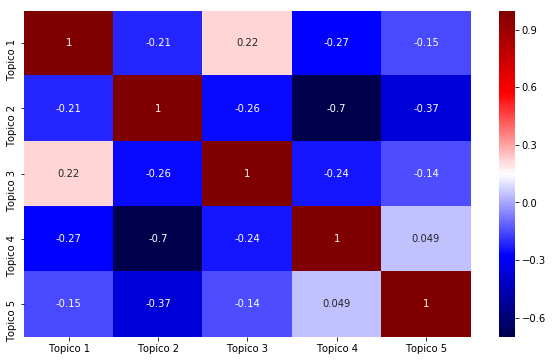

In [25]:
sns.heatmap(topic_for_each_doc.corr(), annot=True, cmap='seismic')

> De las correlaciones entre las probabilidades de las clases se observa que tanto las tematicas del Pop (Tópico 2) como el HipHop (Tópico 4) tienen una correlación relativamente alta pero de manera inversa, indicándonos que estas clases tienen probabilidades con dirección inversa en los datos. Es decir que cuando hay alta probabilidad de que las letras de una canción aborden temáticas del tópico 2 habrá baja probabilidad de que las mismas letras aborden temáticas del tópico 4.

___
* Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.

In [27]:
df_pink_floyd = df_concat[df_concat['Artis']== 'Pink Floyd']

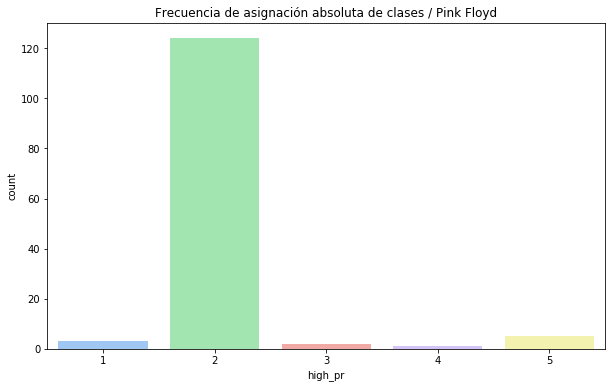

In [28]:
sns.countplot(df_pink_floyd['high_pr'])
plt.title("Frecuencia de asignación absoluta de clases / Pink Floyd");

In [29]:

np.round(df_pink_floyd['high_pr'].value_counts('%')*100, 2)

2    91.85
5     3.70
1     2.22
3     1.48
4     0.74
Name: high_pr, dtype: float64

>Para __Pink Floys__, la probabilidad de pertenecer al __Tópico 2__ (temáticas del Pop) es muy alta __(91.85%)__, lo que difiere con el género musical __rock__ y se ratifica que el Rock y el Pop tocan temáticas que se mezclan.

___
* Grafique la distribución de las probabilidades para algún artista en específico.

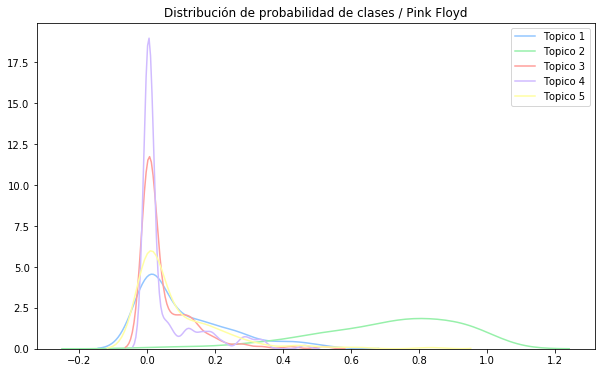

In [30]:
sns.distplot(df_pink_floyd['Topico 1'], label='Topico 1', axlabel='', hist=False)
sns.distplot(df_pink_floyd['Topico 2'], label='Topico 2', axlabel='', hist=False)
sns.distplot(df_pink_floyd['Topico 3'], label='Topico 3', axlabel='', hist=False)
sns.distplot(df_pink_floyd['Topico 4'], label='Topico 4', axlabel='', hist=False)
sns.distplot(df_pink_floyd['Topico 5'], label='Topico 5', axlabel='', hist=False)
plt.title("Distribución de probabilidad de clases / Pink Floyd")
plt.legend();

In [31]:
df_pink_floyd.sample()

,Artis,Genre,Song,Lyrics,Topico 1,Topico 2,Topico 3,Topico 4,Topico 5,high_pr
40,Pink Floyd,rock,A Pillow Of Winds,A cloud of eiderdown draws around me softening...,0.255,0.736,0.003,0.003,0.003,2


> Del gráfico de probabilidades y el de frecuencias podemos observar que la música de Pink Floyd cae en el tópico 2, donde se observaron temáticas tocadas en la música POP, no obstante la música de Pink Floyd está claramente enmarcada en el género Rock, lo que nos hace pensar que el Rock y el Pop son la misma cosa, sólo cambia el ritmo, o estamos frente a un modelo que no nos sirve para esta base de datos y debemos avanzar por otras alternativas.